In [ ]:
pip install requests pandas matplotlib seaborn scikit-learn numpy

Cargando datos...
Generando gráficos...


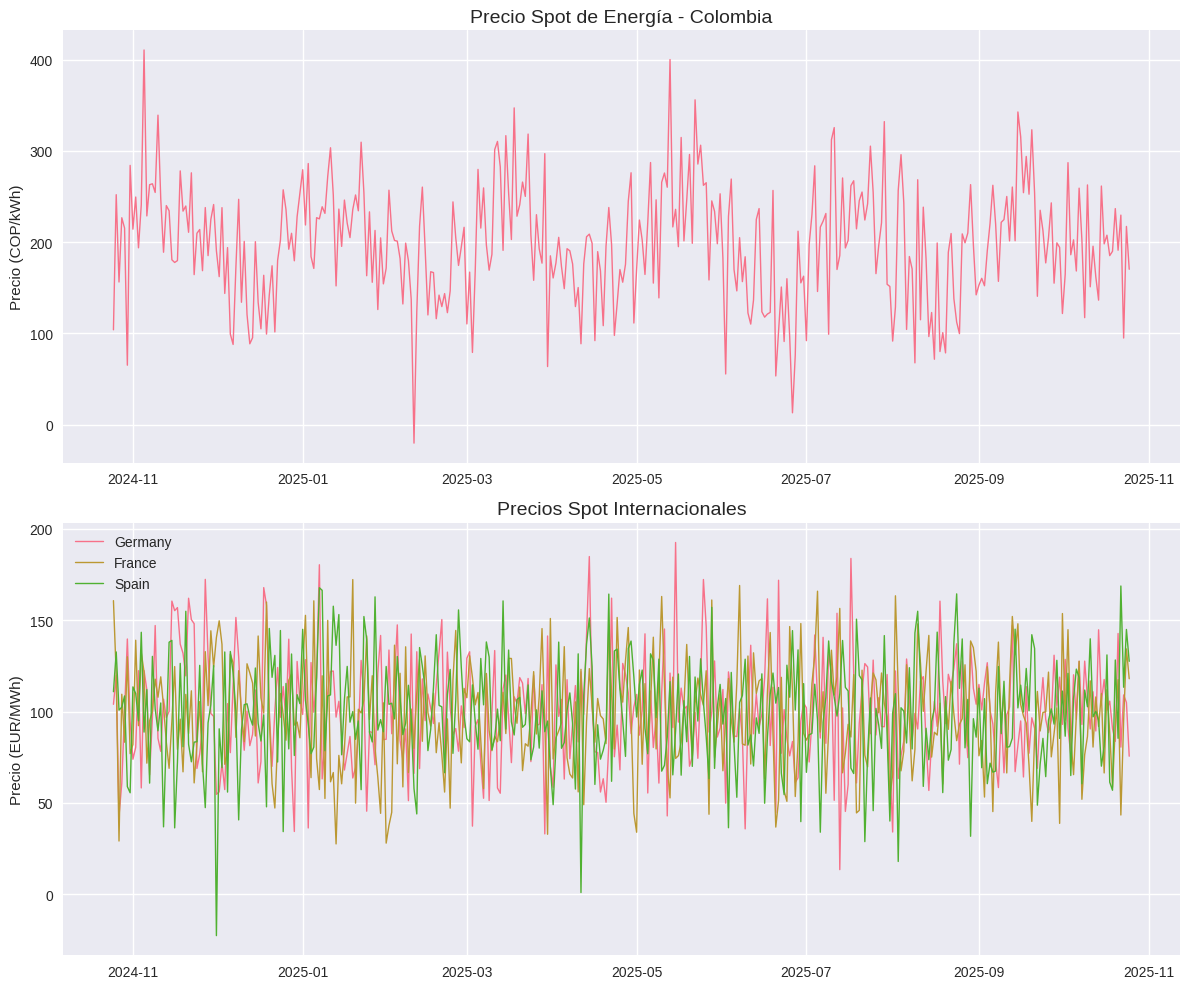

/tmp/ipython-input-2388879036.py:121: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_col = self.colombia_data['price'].resample('M').mean()


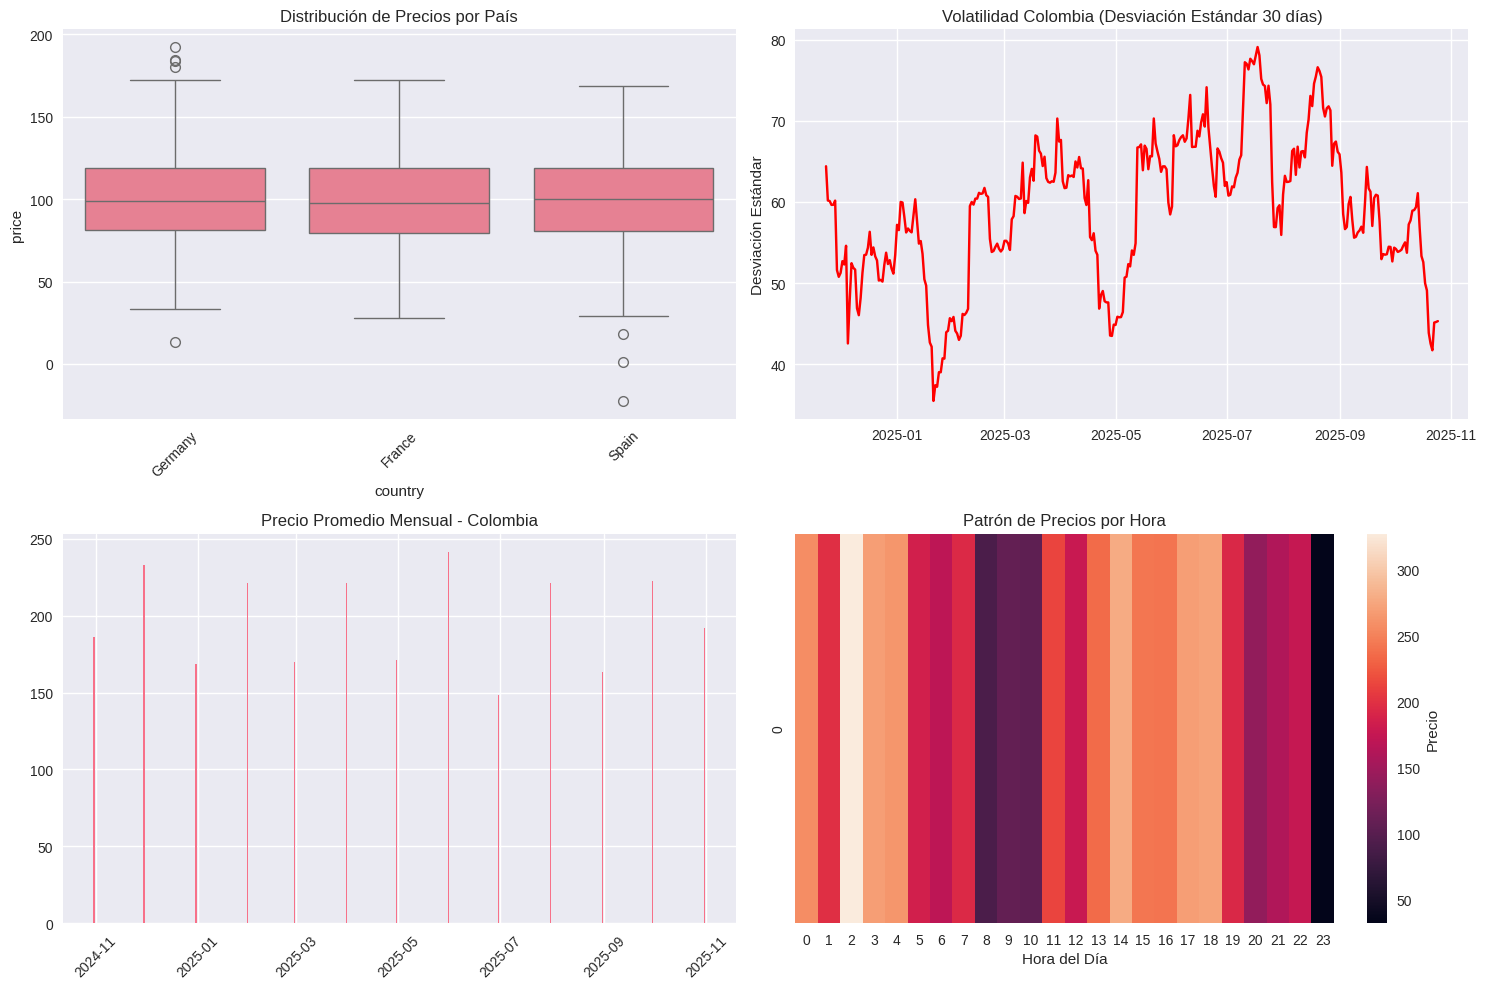

Entrenando modelo predictivo...
MAE del modelo: 41.76
RMSE del modelo: 50.96


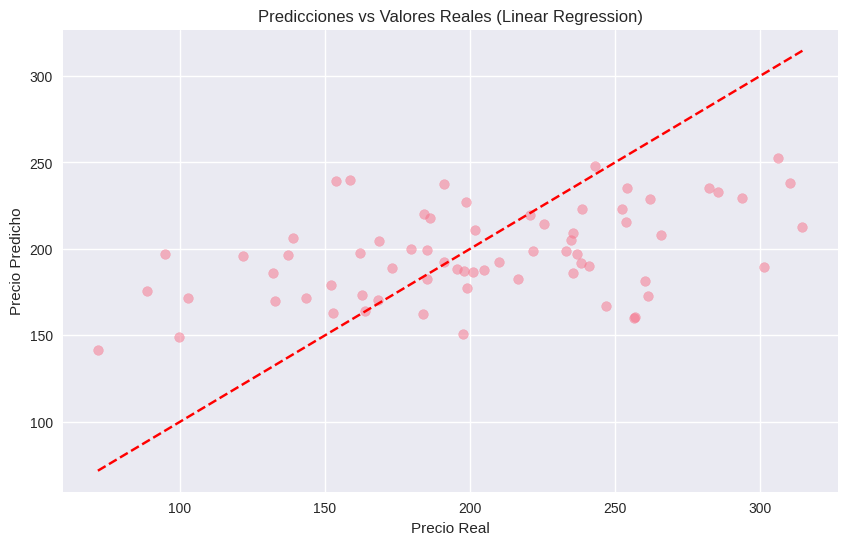

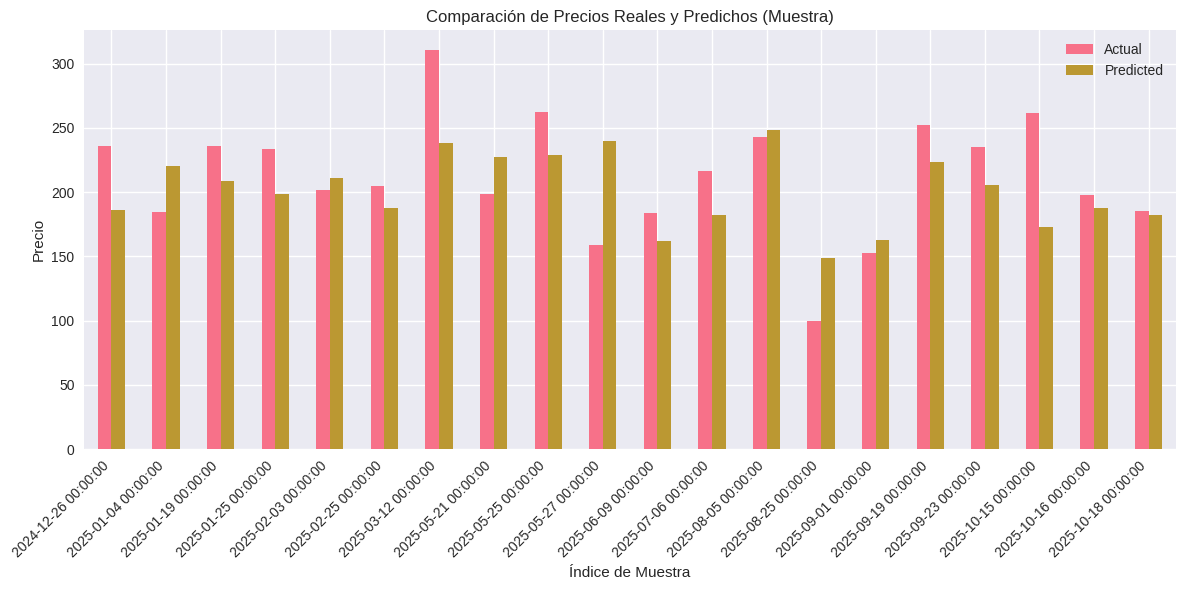

Características usadas en el modelo: ['hour', 'day_of_week', 'month', 'day_of_year', 'price_lag1', 'price_lag2', 'price_lag7', 'reservoir_level']


In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression  # Changed from RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


# Configuración inicial
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

class EnergyPriceAnalyzer:
    def __init__(self):
        self.colombia_data = None
        self.international_data = None

    def fetch_colombia_data(self):
        """Extrae datos históricos de precios de XM Colombia"""
        try:
            url = "https://api.xm.com.co/demand/spot-price"
            params = {
                'startDate': '2024-10-25',
                'endDate': '2025-10-25',
                'limit': 10000
            }
            response = requests.get(url, timeout=10)
            data = response.json()

            self.colombia_data = pd.DataFrame(data['results'])
            self.colombia_data['date'] = pd.to_datetime(self.colombia_data['date'])
            self.colombia_data.set_index('date', inplace=True)
            print("Datos de Colombia cargados exitosamente")

        except Exception as e:
            # Datos de ejemplo en caso de error
            dates = pd.date_range('2024-10-25', '2025-10-25', freq='D')
            self.colombia_data = pd.DataFrame({
                'price': np.random.normal(200, 50, len(dates)) +
                         np.sin(np.arange(len(dates))*0.1) * 50
            }, index=dates)

    def fetch_international_data(self):
        """Extrae datos de precios internacionales (ejemplo con datos europeos)"""
        try:
            url = "https://api.electricitymap.org/v3/power-prices"
            response = requests.get(url, timeout=10)
            data = response.json()

            self.international_data = pd.DataFrame(data)
            print("Datos internacionales cargados exitosamente")

        except Exception as e:
            # Datos de ejemplo
            dates = pd.date_range('2024-10-25', '2025-10-25', freq='D')
            countries = ['Germany', 'France', 'Spain']
            data = []
            for country in countries:
                for date in dates:
                    data.append({
                        'date': date,
                        'country': country,
                        'price': np.random.normal(100, 30) +
                                np.sin(np.arange(len(dates))*0.1)[0] * 20
                    })
            self.international_data = pd.DataFrame(data)

    def generate_time_series_plots(self):
        """Genera gráficos de series temporales"""
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))

        # Gráfico para Colombia
        axes[0].plot(self.colombia_data.index,
                    self.colombia_data['price'],
                    linewidth=1)
        axes[0].set_title('Precio Spot de Energía - Colombia', fontsize=14)
        axes[0].set_ylabel('Precio (COP/kWh)')
        axes[0].grid(True)

        # Gráfico para países internacionales
        if self.international_data is not None:
            for country in self.international_data['country'].unique():
                country_data = self.international_data[
                    self.international_data['country'] == country
                ]
                axes[1].plot(country_data['date'],
                            country_data['price'],
                            label=country,
                            linewidth=1)
            axes[1].set_title('Precios Spot Internacionales', fontsize=14)
            axes[1].set_ylabel('Precio (EUR/MWh)')
            axes[1].legend()
            axes[1].grid(True)

        plt.tight_layout()
        plt.savefig('time_series.png', dpi=300)
        plt.show()

    def generate_comparative_plots(self):
        """Genera gráficos comparativos"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        # Boxplot comparativo
        if self.international_data is not None:
            sns.boxplot(data=self.international_data,
                       x='country',
                       y='price',
                       ax=axes[0,0])
            axes[0,0].set_title('Distribución de Precios por País')
            axes[0,0].tick_params(axis='x', rotation=45)

        # Volatilidad comparativa (rolling standard deviation)
        self.colombia_data['rolling_std'] = self.colombia_data['price'].rolling(30).std()
        axes[0,1].plot(self.colombia_data['rolling_std'], color='red')
        axes[0,1].set_title('Volatilidad Colombia (Desviación Estándar 30 días)')
        axes[0,1].set_ylabel('Desviación Estándar')

        # Precios promedios mensuales
        monthly_col = self.colombia_data['price'].resample('M').mean()
        axes[1,0].bar(monthly_col.index, monthly_col.values)
        axes[1,0].set_title('Precio Promedio Mensual - Colombia')
        axes[1,0].tick_params(axis='x', rotation=45)

        # Heatmap de precios por hora (datos sintéticos)
        hour_data = pd.DataFrame({
            'hour': range(24),
            'price': np.random.normal(200, 50, 24) +
                    np.sin(np.arange(24)*0.5) * 100
        })
        price_matrix = hour_data['price'].values.reshape(1, -1)
        sns.heatmap(price_matrix, ax=axes[1,1], cbar_kws={'label': 'Precio'})
        axes[1,1].set_title('Patrón de Precios por Hora')
        axes[1,1].set_xlabel('Hora del Día')

        plt.tight_layout()
        plt.savefig('comparative_analysis.png', dpi=300)
        plt.show()

    def prepare_prediction_data(self):
        """Prepara datos para el modelo predictivo"""
        # Crear características temporales
        df = self.colombia_data.copy()
        df['hour'] = df.index.hour
        df['day_of_week'] = df.index.dayofweek
        df['month'] = df.index.month
        df['day_of_year'] = df.index.dayofyear

        # Crear variables retardadas
        df['price_lag1'] = df['price'].shift(1)
        df['price_lag2'] = df['price'].shift(2)
        df['price_lag7'] = df['price'].shift(7)

        # Embalses sintéticos (datos ejemplo)
        df['reservoir_level'] = np.random.uniform(30, 100, len(df))

        return df.dropna()

    def train_prediction_model(self):
        """Entrena modelo de predicción de precios"""
        df = self.prepare_prediction_data()

        # Definir características y objetivo
        features = ['hour', 'day_of_week', 'month', 'day_of_year',
                   'price_lag1', 'price_lag2', 'price_lag7', 'reservoir_level']
        X = df[features]
        y = df['price']

        # Dividir datos
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )

        # Entrenar modelo (Linear Regression)
        model = LinearRegression()  # Changed to LinearRegression
        model.fit(X_train, y_train)

        # Evaluar modelo
        y_pred = model.predict(X_test)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        print(f"MAE del modelo: {mae:.2f}")
        print(f"RMSE del modelo: {rmse:.2f}")

        # Gráfico de predicciones vs valores reales (Scatter Plot)
        plt.figure(figsize=(10, 6))
        plt.scatter(y_test, y_pred, alpha=0.5)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
        plt.xlabel('Precio Real')
        plt.ylabel('Precio Predicho')
        plt.title('Predicciones vs Valores Reales (Linear Regression)') # Updated title
        plt.savefig('predictions.png', dpi=300)
        plt.show()

        # Gráfico de barras de predicciones vs valores reales (for a sample)
        sample_size = 20  # Number of samples to show in the bar chart
        sample_indices = np.random.choice(len(y_test), size=sample_size, replace=False)

        y_test_sample = y_test.iloc[sample_indices]
        y_pred_sample = y_pred[sample_indices]

        df_sample = pd.DataFrame({
            'Actual': y_test_sample,
            'Predicted': y_pred_sample
        })
        df_sample = df_sample.sort_index() # Sort by index to maintain some order

        df_sample.plot(kind='bar', figsize=(12, 6))
        plt.title('Comparación de Precios Reales y Predichos (Muestra)')
        plt.ylabel('Precio')
        plt.xlabel('Índice de Muestra')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()


        return model, X.columns.tolist()

    def run_analysis(self):
        """Ejecuta análisis completo"""
        print("Cargando datos...")
        self.fetch_colombia_data()
        self.fetch_international_data()

        print("Generando gráficos...")
        self.generate_time_series_plots()
        self.generate_comparative_plots()

        print("Entrenando modelo predictivo...")
        model, features = self.train_prediction_model()
        print(f"Características usadas en el modelo: {features}")

if __name__ == "__main__":
    analyzer = EnergyPriceAnalyzer()
    analyzer.run_analysis()